## Fama-MacBeth regression

In [3]:
import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# 2000~2020 월별 수익률
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2000', end='2020-12')[0]
ff_factor_data.info()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
 5   RF      252 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


In [8]:
# 17개 산업군의 월별 포트폴리오 수익률
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2000', end='2020-12')[0]
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    252 non-null    float64
 1   Mines   252 non-null    float64
 2   Oil     252 non-null    float64
 3   Clths   252 non-null    float64
 4   Durbl   252 non-null    float64
 5   Chems   252 non-null    float64
 6   Cnsum   252 non-null    float64
 7   Cnstr   252 non-null    float64
 8   Steel   252 non-null    float64
 9   FabPr   252 non-null    float64
 10  Machn   252 non-null    float64
 11  Cars    252 non-null    float64
 12  Trans   252 non-null    float64
 13  Utils   252 non-null    float64
 14  Rtail   252 non-null    float64
 15  Finan   252 non-null    float64
 16  Other   252 non-null    float64
dtypes: float64(17)
memory usage: 35.4 KB


In [9]:
# 포트폴리오 수익률 - 무위험 수익률 = 초과 수익률  : capm
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)

# 무위험 수익률 변수를 제외한 5개 팩터 변수만 남김
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


# # Step 1: Factor Exposures

In [10]:

betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], # 종속변수 
                exog=add_constant(ff_factor_data) # 독립변수
                ).fit()
    betas.append(step1.params.drop('const'))

betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  17 non-null     float64
 1   SMB     17 non-null     float64
 2   HML     17 non-null     float64
 3   RMW     17 non-null     float64
 4   CMA     17 non-null     float64
dtypes: float64(5)
memory usage: 1.3+ KB


c:\users\jyb\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
betas


,Mkt-RF,SMB,HML,RMW,CMA
Food,0.649977,-0.098335,-0.058774,0.443940,0.391866
Mines,1.102191,0.542290,-0.053591,0.456243,0.346071
Oil,1.094864,0.266769,0.314489,0.562737,0.099153
Clths,1.127532,0.290056,0.300332,0.686104,-0.176844
Durbl,1.212371,0.487245,0.125131,0.474321,0.205879
Chems,1.228701,0.119512,0.264200,0.449599,-0.016067
Cnsum,0.685525,-0.298848,-0.190488,0.215775,0.585413
Cnstr,1.139974,0.315498,0.234258,0.368537,-0.039743
Steel,1.560366,0.428161,0.158715,-0.063978,0.011892
FabPr,1.131963,0.340113,0.084075,0.614633,0.071783


## Step 2: Risk Premia

In [12]:

lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], # 종속변수
                exog=betas # 독립변수
                ).fit()
    lambdas.append(step2.params)

lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
dtypes: float64(5)
memory usage: 19.9 KB


In [13]:
lambdas.mean()

Mkt-RF    0.576066
SMB      -0.524737
HML      -0.173916
RMW       0.603397
CMA      -0.047830
dtype: float64

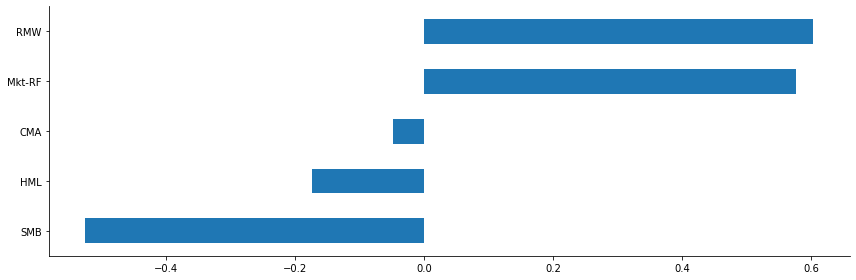

In [14]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [15]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.123797
SMB      -0.073233
HML      -0.037479
RMW       0.123058
CMA      -0.007142
dtype: float64

In [ ]:
# 아래는 2단계 추정의 결과로 산출된 계수 값들을 2년 단위로 이동평균을 계산하여 그래프를 그린 것이다. 
# 계수 추정치가 시간의 흐름에 따라 크게 변하지는 않는지 확인하기 위한 것으로 보면 된다.

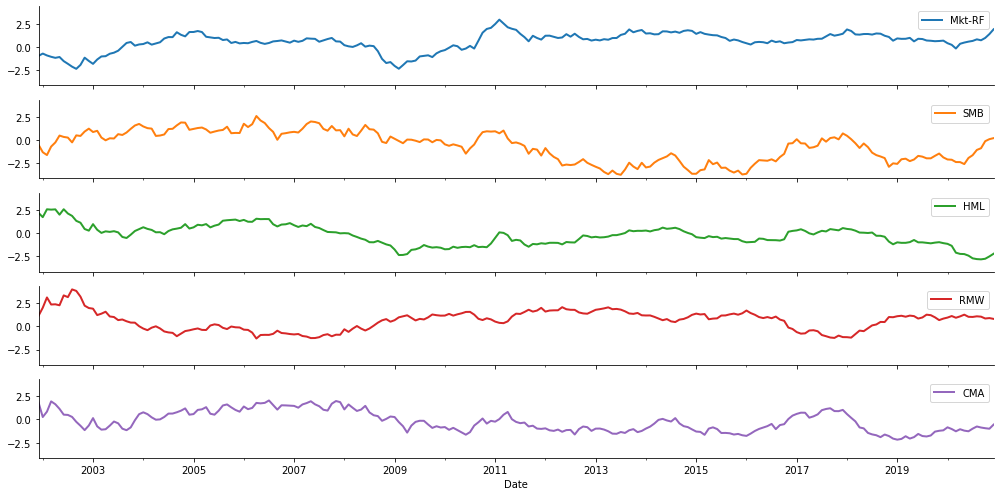

In [16]:
window = 24  # months
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()

In [ ]:
# LinearModels 라이브러리는 statsmodels 라이브러리를 확장하여 패널 데이터를 다루기 위한 다양한 모델을 제공하고 파마-맥베스 회귀 모형도 제공한다. 
# 위에서 2-step으로 직접구현한 결과와 동일한 계수 추정치를 얻을 수 있다.

In [17]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6829
No. Factors:                          5   J-statistic:                    12.797
No. Observations:                   252   P-value                         0.3840
Date:                  Tue, Mar 08 2022   Distribution:                 chi2(12)
Time:                          11:21:40                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.5761     0.3015     1.9104     0.0561     -0.0149      1.1671
SMB           -0.5247     0.5311    

In [18]:
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6829
No. Factors:                          5   J-statistic:                    12.797
No. Observations:                   252   P-value                         0.3840
Date:                  Tue, Mar 08 2022   Distribution:                 chi2(12)
Time:                          11:21:40                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.5761     0.3015     1.9104     0.0561     -0.0149      1.1671
SMB           -0.5247     0.5311    